<a id='Contents'></a>

# Table of Contents

* [About the Notebook](#About)
* [Importing libraries](#lib)
* [Importing dataset](#dt)
    * [Feature engineering](#Missing)
    * [Describe the dataframe](#Describe)
    * [Model input](#Input)
* [Gradient Boosting Classifier](#Gradient)
* [Analyzing the Gradient Model](#AnalyzingtheGradientModel)
    * [Plot tree](#plot_tree)
    * [Terminal Leaves](#terminal_leaves_def)
        * [B-spline function](#B-spline)
    * [Decision Boundaries](#Decision_Boundaries_def)
        * [Regression Decision Boundaries](#Decision_Boundaries_reg)
        * [Classification Decision Boundaries](#Decision_Boundaries_clf)
* [Conclusion](#Conclusion)

<a id='About'></a>
# About the Notebook
[Table of Contents](#Contents)

The focus of this study is to introduce different analysis aspects of the Gradient Boosting Models. As in many studies and literature, the goal is the final accuracy of the model or the classification precision, I tried to prepare different analyses in this work. 

The following experiments are reviewed as the Boosting metrics

* Plotting the Decision tree
* The values of the terminal region
* Computing the interpolating B-spline.
* Decision boundaries

Of course, each part has its own interpretation and strategy for the implementation. Check each cell for its details.

Author: [Seyedsaman Emami](https://samanemami.github.io/)

<a id='lib'></a>
# Importing libraries
[Table of Contents](#Contents)

---

Author: [Seyedsaman Emami](https://samanemami.github.io/)

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from scipy.special import logsumexp
from sklearn.preprocessing import LabelEncoder
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import warnings
random_state = 123
np.random.seed(random_state)

warnings.simplefilter('ignore')

np.set_printoptions(precision=4, suppress=True)

sns.set_theme()

In [3]:
def make_pretty(styler):
    styler.set_caption("Weather Conditions")
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="YlGnBu")
    return styler

<a id='dt'></a>
# Importing dataset
[Table of Contents](#Contents)

The `RiverFlow-2` Dataset has 9125 instances and 576 features with eight continuous targets.

In [4]:
df = pd.read_csv('../input/iris/Iris.csv')
df.head().style.pipe(make_pretty)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,2,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,3,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5,5.000000,3.600000,1.400000,0.200000,Iris-setosa


<a id='Missing'></a>
## Feature engineering
[Table of Contents](#Contents)


In [5]:
df = df.drop('Id', axis=1)

<a id='Describe'></a>
## Describe the dataframe
[Table of Contents](#Contents)

In [6]:
df.describe().style.pipe(make_pretty)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


<a id='Input'></a>
## Model Input
[Table of Contents](#Contents)


Due to some of the 2-D dimensional experiments, only two of the four features are considered as the model input.

Author: [Seyedsaman Emami](https://samanemami.github.io/)

In [8]:
X = (df.drop(columns=["Species"])).values
y = (df["Species"]).values


lb = LabelEncoder()
y = lb.fit_transform(y)

X = X[:, 2:]
print(X.shape, y.shape)

(150, 2) (150,)


In [9]:
n_classes = len(np.unique(y))
n_classes

3

<a id='Gradient'></a>
# Gradient Boosting Classifier
[Table of Contents](#Contents)

Fitting Gradient Boosting Classifier model on the iris dataset

In [10]:
gb = GradientBoostingClassifier(max_depth=5,
                                subsample=0.75,
                                max_features="sqrt",
                                learning_rate=0.1,
                                random_state=random_state,
                                criterion="squared_error",
                                n_estimators=100)

gb.fit(X, y)

GradientBoostingClassifier(criterion='squared_error', max_depth=5,
                           max_features='sqrt', random_state=123,
                           subsample=0.75)

<a id='AnalyzingtheGradientModel'></a>
# Analyzing the Gradient Model
[Table of Contents](#Contents)

<a id='plot_tree'></a>
## Plot tree
[Table of Contents](#Contents)

> Draw the first decision Tree for each class

The first decision tree regressor of each class is plotted with the values of the impurity (MSE) and the final predicted values

In [11]:
def plot(tree, axs):

    plot_tree(tree, filled=True, rounded=True,
              precision=2, ax=axs, label="root")

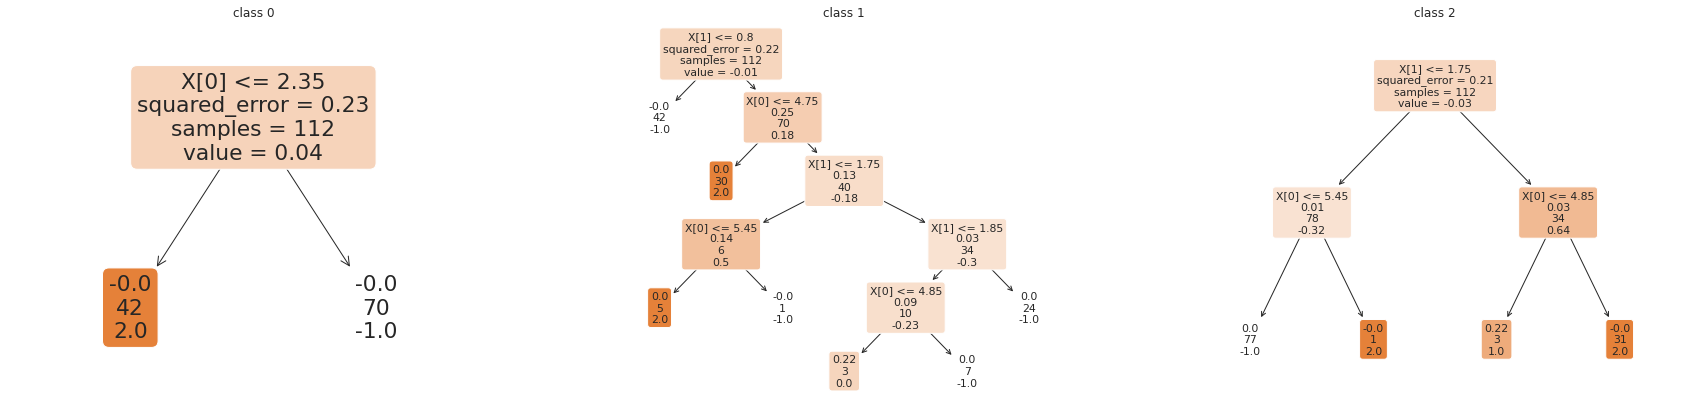

In [12]:
fig1, axs1 = plt.subplots(1, 3, figsize=(30, 7), facecolor="w")

# Plot (Tree) two first class only
for i in range(n_classes):
    tree_gb = gb.estimators_[0][i]
    plot(tree_gb, axs1[i])
    axs1[i].set_title("class " + str(i))

<a id='terminal_leaves_def'></a>
## Terminal leaves
[Table of Contents](#Contents)

> Returning the Terminal values of the trees

The regression values of the terminal of final nodes of each class and first tree are plotted

Author: [Seyedsaman Emami](https://samanemami.github.io/)

In [13]:
def terminal_leaves(model, tree, class_):
    # Return the terminal regions values
    est = model.estimators_[tree][class_]
    children_left = est.tree_.children_left
    children_right = est.tree_.children_right
    n_nodes = est.tree_.node_count
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)] 
    while len(stack) > 0:
        node_id, depth = stack.pop()

        is_split_node = children_left[node_id] != children_right[node_id]

        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True
    terminal_leave = est.tree_.value[np.where(is_leaves == True)]
    terminal_leave = terminal_leave.reshape(-1, 1)[:, 0]
    return terminal_leave

Text(0.5, 0.98, 'Terminal continuous values of the decision tree regressor')

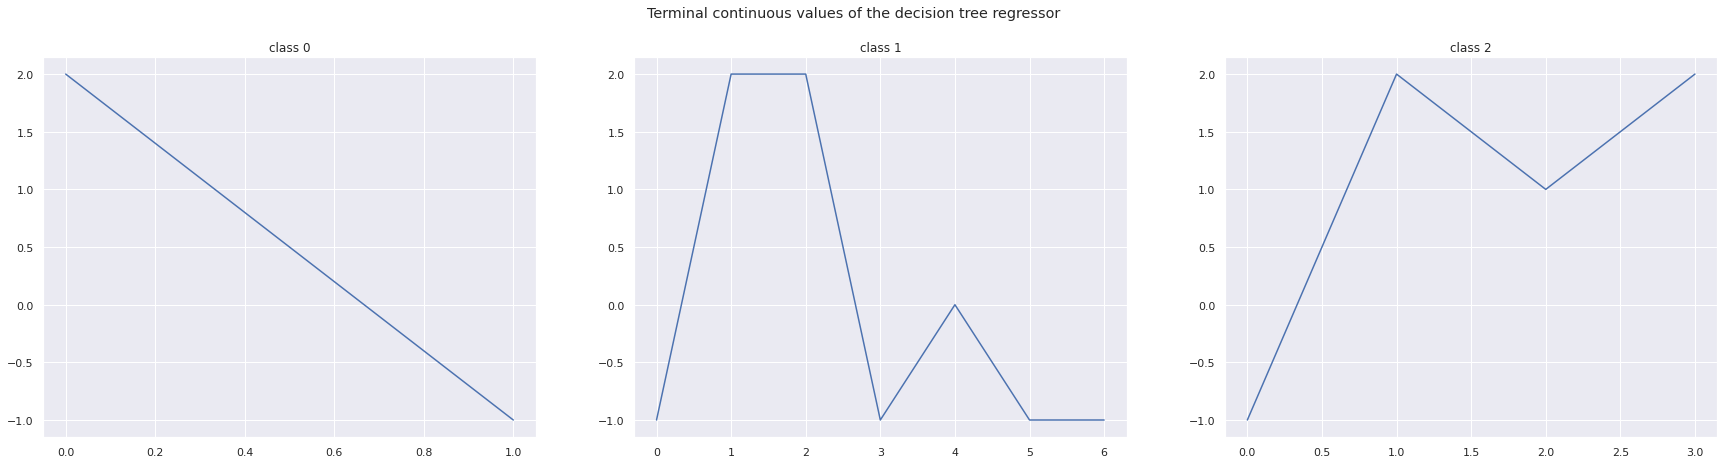

In [14]:
fig2, axs2 = plt.subplots(1, 3, figsize=(30, 7), facecolor="w")

# Plot (Tree) two first class only
for i in range(n_classes):
    axs2[i].plot(terminal_leaves(gb, 0, i))
    axs2[i].set_title("class " + str(i))
fig2.suptitle("Terminal continuous values of the decision tree regressor")

In [15]:
def interpolating(data):
    y = [i for i in range(data.shape[0])]
    idx = range(len(y))
    x = np.linspace(min(idx), max(idx), 300)

    spl = make_interp_spline(idx, data, k=3)
    smooth = spl(x)

    return x, smooth

<a id='B-spline'></a>
### B-spline function
[Table of Contents](#Contents)


The regression values of the terminal of final nodes (smoothed curve of the leaves values) of the last class



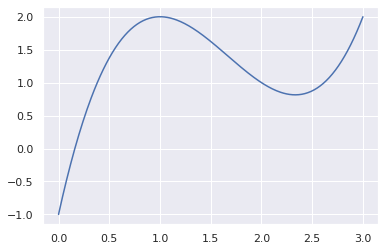

In [16]:
x_new, smooth = interpolating(terminal_leaves(gb, 0, 2))
plt.plot(x_new, smooth)

<a id='Decision_Boundaries_def'></a>
## Decision Boundaries
[Table of Contents](#Contents)

* Decision boundaries for the regression values of n_estimators (100 regression trees) and each class.
* Decision boundaries of the predicted values (converted to clf) of the first decision tree regressor and each class.

In [17]:
def boundaries(X=np.array,
               y=np.array,
               model=np.array,
               tree=0,
               class_=-1,
               title='title',
               axs=plt.axes):

    level = 11
    cm = plt.cm.viridis

    n_classes = len(np.unique(y))
    n_estimator = model.get_params()['n_estimators']
    learning_rate = model.get_params()['learning_rate']
    regression = True if class_ >= 0 else False

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    pred = np.zeros((xx.ravel().shape[0], n_classes))

    if not regression:
        # Plot the Decision boundary for one tree only
        for i in range(n_classes):
            tree_ = model.estimators_[tree][i]
            pred_ = tree_.predict(np.c_[xx.ravel(), yy.ravel()])
            pred[:, i] = pred_ * learning_rate
    else:
        # Plot the Decision boundary for all of the trees
        for c in range(n_classes):
            for i in range(n_estimator):
                tree_ = model.estimators_[i][c]
                pred[:, c] += (learning_rate *
                               tree_.predict(np.c_[xx.ravel(),
                                                   yy.ravel()]))

    if not regression:
        # Return Decision boundary for one tree and predict_proba (classification).
        proba = np.nan_to_num(
            np.exp(pred - (logsumexp(pred, axis=1)[:, np.newaxis])))
        Z = np.argmax(proba, axis=1)
        Z = Z.reshape(xx.shape)

        axs.contourf(xx, yy, Z, level, alpha=1, cmap=cm)
        CS = axs.contourf(xx, yy, Z, level, cmap=cm, shrink=0.9)
        axs.contour(xx, yy, Z, [0.0], linewidths=2, colors='k')
        axs.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k')
    else:
        # Return Decision boundary for one tree and predict (Regression)
        Z = pred[:, class_].reshape(xx.shape)

        axs.contourf(xx, yy, Z, level, alpha=1, cmap=cm)
        CS = axs.contourf(xx, yy, Z, level, cmap=cm, shrink=0.9)

    axs.set_title(title)

    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())

    axs.grid(True)

    return CS

<a id='Decision_Boundaries_reg'></a>
### Regression Decision Boundaries
[Table of Contents](#Contents)

This part reveals the decision tree regressor models (Boosting base learners) performance. 

Their prediction of the previous residual is accumulated by considering the learning rate and all the prior boosting steps.

You can find the regression performance of each class separately with the range of the predicted values.

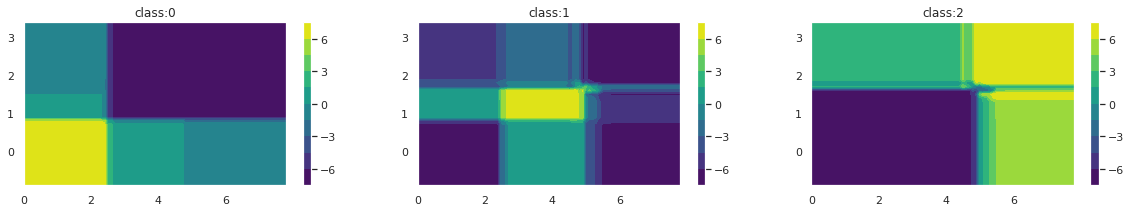

In [18]:
fig3, axs3 = plt.subplots(1, 3, figsize=(20, 3), facecolor="w")

for i in range(n_classes):
    CS = boundaries(X=X, y=y, model=gb, class_=i,
                    title='class:' + str(i), axs=axs3[i])
    fig3.colorbar(CS, ax=axs3[i])

<a id='Decision_Boundaries_clf'></a>
### Classification Decision Boundaries
[Table of Contents](#Contents)

The main difference between this plot and the previous one is that this one is for the first-week learner (not all the estimators). 

Moreover, here I am plotting the decision boundary of the classifier, which means I transformed the prediction to probability and found the class label with regards to all the class labels. 

Author: [Seyedsaman Emami](https://samanemami.github.io/)

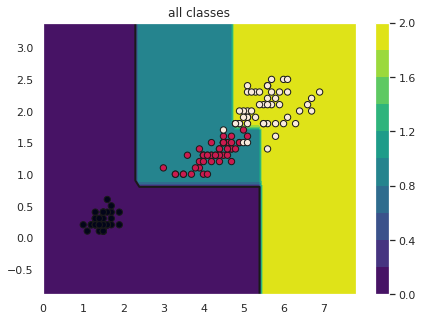

In [19]:
fig3, axs3 = plt.subplots(1, 1, figsize=(7, 5), facecolor="w")

CS = boundaries(X=X, y=y, model=gb, tree=0, class_=-1,
                title='all classes', axs=axs3)
fig2.colorbar(CS, ax=axs3)

<a id='Conclusion'></a>
# Conclusion
[Table of Contents](#Contents)

In this Notebook, The performance of the week learners of the Boosting Machine, which is a well-known ensemble model is analyzed.

This study is different from the ones, which are considering the ensemble performance. Unlike other studies, here I concentrated on the performances of the decision trees.

Author: [Seyedsaman Emami](https://samanemami.github.io/)